In [35]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools

from tqdm import tqdm_notebook as tqdm

from graph_utils.generate_graph import generate_graph
from graph_utils.utils import pp, miia, mip, mioa, in_neighbors
from graph_utils.greedy_ic import naive_greedy_algorithm, ap

## Initial setup

In [36]:
grph = generate_graph(num_nodes_min_max=[50, 55], directed=True)

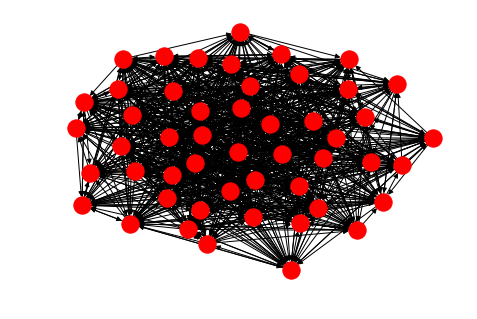

In [37]:
nx.draw(grph)

Text(0.5, 1.0, 'Histogram of transition probabilities')

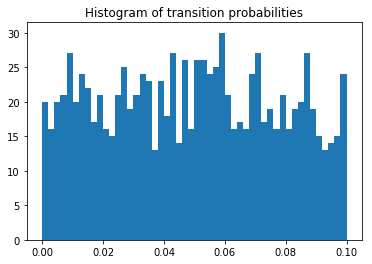

In [38]:
plt.hist([i['transition_proba'] for i in list(grph.edges.values())], bins=50)
plt.title("Histogram of transition probabilities")

Text(0.5, 1.0, 'Histogram of -log-transition probabilities')

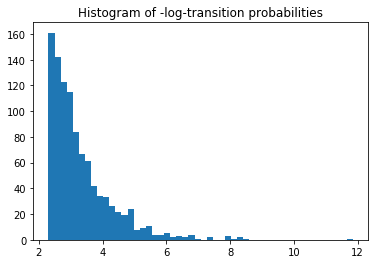

In [39]:
plt.hist([i['log_transition_proba'] for i in list(grph.edges.values())], bins=50)
plt.title("Histogram of -log-transition probabilities")

In [40]:
s = naive_greedy_algorithm(4, grph, tqdm)

In [27]:
sum(ap(i, s, miia(i, 0.001, grph), grph) for i in grph.nodes)

26.05347818637536

In [28]:
s

[0, 1, 3, 6]

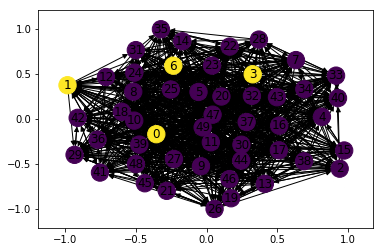

In [29]:
nx.draw_networkx(grph, node_color=[(10 if i in s else 9) for i in grph.nodes])

In [34]:
list(grph.predecessors(0))

[2, 8, 13, 15, 17, 18, 19, 24, 29, 31, 32, 41, 44, 47, 48, 49]

In [11]:

def hsh(i, lst):
    return int( str(hash(repr(lst))) + str(hash(i)))
    
def ap(u, S, miia_v_theta, grph, cache):
    """ Compute activation probability of node 
    u, from set S and maximum influence in-arboresence
    miia_v_theta.
    """
    n_in = in_neighbors(u, miia_v_theta)
    if u in S:
        return 1.
    elif not len(n_in):
        return 0.
    else:
        base = 1
        for in_neighbor in n_in:
            if hsh(in_neighbor, miia_v_theta) in cache:
                p = cache[hsh(in_neighbor, miia_v_theta)]
            else:
                p =  ap(in_neighbor, S, miia_v_theta, grph, cache)
                cache[hsh(in_neighbor, miia_v_theta)] = p
            base *= (1 - p*pp(in_neighbor, u, grph))
        return 1 - base

In [15]:
sd = {}

In [18]:
for i in range(50):
    ap(i, [1], miia(i, 0.001, grph), grph, sd)

In [41]:
S = [2]
cache = {}
children = {}
tree = sorted(miia(0, 0.001, grph), key=lambda x: -len(x))
for path in tree:

    for i in range(1, len(path)):
        if path[i] in children:
            children[path[i]].append(path[i-1])
        else:
            children[path[i]] = [path[i-1]]
    
    if not path[0] in cache: 
        cache[path[0]] = 1 if path[0] in S else 0
        path.pop(0)

In [43]:
#PMIA

s = []
inc_inf = np.zeros(grph.number_of_nodes())

for node in grph.nodes:
    

In [45]:
grph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49))